In [35]:
""" 

ADOBE CONFIDENTIAL
Copyright 2024 Adobe
All Rights Reserved.
NOTICE: All information contained herein is, and remains
the property of Adobe and its suppliers, if any. The intellectual
and technical concepts contained herein are proprietary to Adobe
and its suppliers and are protected by all applicable intellectual
property laws, including trade secret and copyright laws.
Dissemination of this information or reproduction of this material
is strictly forbidden unless prior written permission is obtained
from Adobe.

This jupyter notebook implements the model editing algorithm - DiffQuickFix from ICLR 2024 paper 'Localizing and Editing Knowledge in Text-to-Image Models '


"""



# Libraries # 
import argparse
import os
import time
import random

from PIL import Image
import numpy as np
import pandas as pd
import torch
from diffusers import StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
import copy 
print(f'Libraries loaded')

Libraries loaded


In [36]:
######################################### DEFINE THE HUGGINGFACE TOKENS #################################################

HF_TOKEN = "##" # Insert your own 
if not HF_TOKEN:
    raise Exception("Huggingface token is required. Please add your HG token to config.py")

In [37]:
# Function to decode the tokens given the tokenizer and an array containing token indices # 
def decode_tokens(tokenizer, token_array):
    if hasattr(token_array, "shape") and len(token_array.shape) > 1:
        return [decode_tokens(tokenizer, row) for row in token_array]
    return [tokenizer.decode([t]) for t in token_array]

In [38]:
# Argument parser # 
def parse_args():
    parser = argparse.ArgumentParser(
        prog='Clip Editor',
        description='A script for running and editing method'
                    'on CLIP and running it on scale')
    parser.add_argument('--file', help='A file for running and testing the editing from')
    parser.add_argument('--dataset', default='TIME', choices=["TIME", "RoAD", "TIME-TEST"])
    parser.add_argument('--data_split', default='validation', choices=["validation", "test"])
    parser.add_argument('--algorithm', default='contrastive', choices=['contrastive', 'direct', 'contrastive_text', 'direct_text','baseline', 'oracle'])
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--model', default='CompVis/stable-diffusion-v1-2')
    parser.add_argument('--clip_model', default='openai/clip-vit-large-patch14-336')

    parser.add_argument('--use_kl_prompts', action='store_true')
    parser.add_argument('--num_kl_prompts', type=int, default=20)
    parser.add_argument('--use_negative_images', action='store_true')
    parser.add_argument('--num_negative_images', type=int, default=200)
    parser.add_argument('--num_editing_images', type=int, default=1)

    parser.add_argument('--use_eos', type=int, default=0)

    # Prompt - Initial
    parser.add_argument('--init_prompt', type=str, default='President of the United States')
    parser.add_argument('--target_prompt', type=str, default='Joe Biden')
    
    # Train
    parser.add_argument('--train_flag', type=str, default='True')

    # Edit layer
    parser.add_argument('--edit_layer', type=int, default = 0, choices=list(range(0,12)))
    parser.add_argument('--v_lr', type=float, default=5e-1)
    parser.add_argument('--v_kl_factor', type=float, default=0)
    parser.add_argument('--v_max_grad_steps', type=int, default=100)
    parser.add_argument('--self_layer', type=int, default=0)
    parser.add_argument('--v_prob_threshold', type=float, default=0.99)
    parser.add_argument('--v_weight_decay_factor', type=float, default=0.1)
    parser.add_argument('--reg', type=float, default=0.1)
    parser.add_argument('--ablation', type=str, default="False")
    parser.add_argument('--v_similarity_metric', default='l2', choices=["l2", "cosine"])
    return parser.parse_args()

In [39]:
# Function for setting the seed # 
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [40]:
# Safety Checker
class SafteyChecker(StableDiffusionSafetyChecker):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, clip_input, images):
        has_nsfw_concepts = [False for _ in range(len(images))]
        return images, has_nsfw_concepts

    def forward_onnx(self, clip_input: torch.FloatTensor, images: torch.FloatTensor):
        has_nsfw_concepts = [False for _ in range(len(images))]
        return images, has_nsfw_concepts

In [41]:
""" 
# Main model editing function which updates the projection matrix of the first self-attention layers in-place
# It directly solves the closed-form solution # 
"""
def train_new(model, projection_matrices, og_matrices, contexts, values, old_texts, new_texts, lamb=0.01):
    print(f'############## Editing function #################')
    # Contexts for the three projection matrices
    context_k = contexts
  
    # Values for the three projection matrices
    values_k = values
   
    # Iterate through the projection matrices
    for layer_num in range(len(projection_matrices)):
        # First layer is v, then k, then q
        with torch.no_grad():
            # mat1 : \lambda Q + \sum v k^{T}
            mat1 = lamb * projection_matrices[layer_num].weight 
            
            # mat2 : \lambda I  + \sum k k^{T}
            mat2 = lamb * torch.eye(projection_matrices[layer_num].weight.shape[1], device = projection_matrices[layer_num].weight.device)

            # Number of updates
            c_total = 0
            for context, value in zip(context_k, values_k):
                # Context vector # 
                context_vector = context.reshape(context.shape[0], context.shape[1], 1)
                # 1 x 768
                context_vector_T = context.reshape(context.shape[0], 1, context.shape[1])

                # 768 x 1
                value_vector = value.reshape(value.shape[0], value.shape[1], 1)

                for_mat1 = (value_vector @ context_vector_T).sum(dim=0)
                for_mat2 = (context_vector @ context_vector_T).sum(dim=0)

                # Update the matrix
                mat1 += for_mat1 
                mat2 += for_mat2 

                c_total += 1
            

        # Projection matric
        projection_matrices[layer_num].weight = torch.nn.Parameter(mat1 @ torch.inverse(mat2))

    # Finished Updating the Weight Matrices 
    print(f'Finished Updating the weight matrices of the self-attention layers ... ')

    
    return 

In [42]:
seed = 0

################### Define the anchor prompt: Prompt containing the concept which needs to be removed ############################# 
anchor_prompt = 'van gogh'

################## Define the target prompt: Prompt to which the original anchor_prompt needs to be translated to ######################
target_prompt = 'painting'

############## Empty cuda cache ############
torch.cuda.empty_cache()

############## Define the gpu ################
device = 'cuda:0'

############################## Define the models ##################################

########### CLIP ##############
clip_model_name = 'openai/clip-vit-large-patch14-336'
model = CLIPModel.from_pretrained(clip_model_name, cache_dir='home/samyadeepb').to(device)
processor = CLIPProcessor.from_pretrained(clip_model_name)

############## Stable-Diffusion ###############
sd_model_name = 'CompVis/stable-diffusion-v1-4'
sd_pipeline = StableDiffusionPipeline.from_pretrained(sd_model_name, use_auth_token=HF_TOKEN)
sd_pipeline.safety_checker = SafteyChecker(sd_pipeline.safety_checker.config)
sd_pipeline = sd_pipeline.to(device)

# Set the seed
set_seed(seed)

########################## Define the self-attention layer which needs to be edited ##########################
self_layer = 0 ## Default = 0, found via causal tracing in the paper

# Regularization for the optimization
reg = 0.01 
# Train Flag
train_flag = False

# Use EOS # : This is a flag variable which lets you use the EOS tokens also in the editing optimization step
use_eos = 1

# Ablation
ablation = True 

########################################## Obtain the projection layers of the self-attentions which needs to be udpated ###################################
# Layers which need to get appended
ca_layers = []
for n, m in model.text_model.named_modules():
    if 'encoder.layers.' + str(self_layer) + '.self_attn' == n:
        ca_layers.append(m)

# Projection Matrices
projection_matrices = [l.out_proj for l in ca_layers]
og_matrices = [copy.deepcopy(l.out_proj) for l in ca_layers]

# Count parameters
def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)


# # Parameters
params = 0
for l in projection_matrices:
    params += l.in_features * l.out_features

    
# Parameters to update
print(f'Params to update : {params}')
print("Total params: ", count_parameters(sd_pipeline.unet))
print("Percentage: ", (params / count_parameters(sd_pipeline.unet)) * 100)



########################################## CREATING THE TRAINING DATA FOR MODEL EDITING ##############################################
# # Setup sentences #
old_texts = [anchor_prompt]
new_texts = [target_prompt]

####################################  Use simple augmentations to expand the training data ########################
# With augmentation
with_augs = True
# With augmentations
if with_augs:
    base = old_texts[0] if old_texts[0][0:1] != "A" else "a" + old_texts[0][1:]
    old_texts.append("A photo of " + base)
    old_texts.append("An image of " + base)
    old_texts.append("A picture of " + base)
    base = new_texts[0] if new_texts[0][0:1] != "A" else "a" + new_texts[0][1:]
    new_texts.append("A photo of " + base)
    new_texts.append("An image of " + base)
    new_texts.append("A picture of " + base)


    
###################################### Obtain the projection matrix embeddings for the tokens of the training data ######################################
text_modules = []
module_k_proj = None 
module_v_proj = None 
module_q_proj = None 

# Iterate through the text_model modules
for n,m in model.text_model.named_modules():
    # Only use the out_proj layer as output
    if 'encoder.layers.' + str(self_layer) + '.self_attn.out_proj' in n:
        text_modules.append(n)
        module_k_proj = m 


# Context / Values 
context_k, values_k = [], []

# Hook attachment for text-embedder
def hook_attach(name):
    def hook(model, inp, out):
        if name == 'out_proj':
            context_k.append(inp[0][0].detach())
            values_k.append(out[1].detach())

    # Return the hook
    return hook 

# Register the hook to obtain the token embeddings # 
h1 = module_k_proj.register_forward_hook(hook_attach('out_proj'))

# # Stores the index of the subjects of the old and new texts
subject_old_texts = []
subject_new_texts = []

# Function to obtain the relevant set of tokens from the tokenizer output #
def find_index(token_temp):
    # Subject old / new tokens
    sub_old_tokens = token_temp[0]
    sub_new_tokens = token_temp[1]

    return_old = 0
    return_new = 0
    c = 0
    for tok in sub_old_tokens:
        if tok == 49407:
            return_old = c - 1
            break 

        c += 1

    c = 0
    for tok in sub_new_tokens:
        if tok == 49407:
            return_new = c - 1
            break 

        c += 1

    return return_old, return_new



# Tracking time # 
t0 = time.time()
t_c = 0
 
###################################### Iterate through the texts and obtain the token embeddings ###############################
for old_text, new_text in zip(old_texts, new_texts):
    # Tokens Old
    tokens = processor.tokenizer([old_text, new_text], padding="max_length", max_length=77, truncation=True, return_tensors="pt").input_ids 
    
    # Obtain the relevant token indexes # 
    old_index, new_index = find_index(tokens)
    
    temp_k = []
    #subject_old_texts.append(old_index)
    temp_k.append(old_index)

    for j in range(old_index+1, 77):
        # ADDED - EOS Token for the keys
        temp_k.append(j)

    # Subject old text tokens
    subject_old_texts.append(temp_k)


    temp_val = []
    temp_val.append(new_index)

    for j in range(new_index+1, 77):
        # ADDED - EOS Token for the values
        temp_val.append(j)

    subject_new_texts.append(temp_val)


    # Call the text-embedding model so that the relevant tokens are saved # 
    with torch.no_grad():
        text_embeddings = model.text_model(tokens.to(model.device))[0]


    t_c += 1


# Refined context / values
refined_context_k, refined_values_k = [], []

# Maintain count
c_key = 0
c_val = 0

contextss = []
valuess = []


# Iterate through the context, values vectors
for i in range(0, len(context_k)):
    # Update the contexts 
    key_indexes = []
    values_indexes = []

    refined_context_k.append(context_k[i][subject_old_texts[i][0]])

    # Changed
    key_indexes.append(subject_old_texts[i][0])

    temp = 0
    subj_eos = 0
    for j in range(1, len(subject_old_texts[i])):
        if use_eos == 1:
            refined_context_k.append(context_k[i][subject_old_texts[i][j]])
            key_indexes.append(subject_old_texts[i][j]) # Added
        temp += 1


    #print(f'Temp: {temp}')
    refined_values_k.append(values_k[i][subject_new_texts[i][0]])
    values_indexes.append(subject_new_texts[i][0])

    temp = 0
    key_eos = 0

    if len(subject_old_texts[i]) <= len(subject_new_texts[i]):
        max_turn = len(subject_old_texts[i])

    else:
        max_turn = len(subject_new_texts[i])
    
    
    for j in range(1, max_turn):
        #refined_values_k.append(values_k[i][subject_new_texts[c_val+1]])
        if use_eos == 1:
            refined_values_k.append(values_k[i][subject_new_texts[i][j]])
            values_indexes.append(subject_new_texts[i][j]) # Changed

        temp += 1

    # 
    if len(key_indexes) <= len(values_indexes):
            contextss.append(context_k[i][key_indexes])
            valuess.append(values_k[i][values_indexes])

    else:
        contextss.append(context_k[i][key_indexes])
        diff = len(key_indexes) - len(values_indexes)
        for k in range(0, diff):
            values_indexes.append(76)

        valuess.append(values_k[i][values_indexes])

        
############################################### END OF OBTAINING THE RELEVANT TOKEN EMBEDDINGS ############################


################################## Check the number of keys and values ###############################
print(f'Length of Keys: {len(refined_context_k)}')
print(f'Length of Values: {len(refined_values_k)}')
# # Context Values
contexts = [refined_context_k]
# # Values 
values = [refined_values_k]

######################################### Training Function ###################################################
train_new(model.text_model, projection_matrices, og_matrices, contextss, valuess, old_texts, new_texts, lamb=reg)
print(f'Training Finished .....')
h1.remove()

Keyword arguments {'use_auth_token': ''} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 12.11it/s]


Random seed set as 0
Params to update : 589824
Total params:  859520964
Percentage:  0.06862241000558073
Length of Keys: 291
Length of Values: 291
############## Editing function #################
Finished Updating the weight matrices of the self-attention layers ... 
Training Finished .....


In [43]:
############### Update the modified text-encoder in SD-pipeline ##########################
print(f'Finished Editing the Model ')
model.text_model.dtype = torch.float32
sd_pipeline.text_encoder.text_model = model.text_model
sd_pipeline = sd_pipeline.to(device)

Finished Editing the Model 


In [50]:
############################### Generate samples with the updated models ################################
seed = 110
set_seed(seed)
target_prompt_final = 'a car in the style of van gogh'
image = sd_pipeline(target_prompt_final)['images'][0]

Random seed set as 110


100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


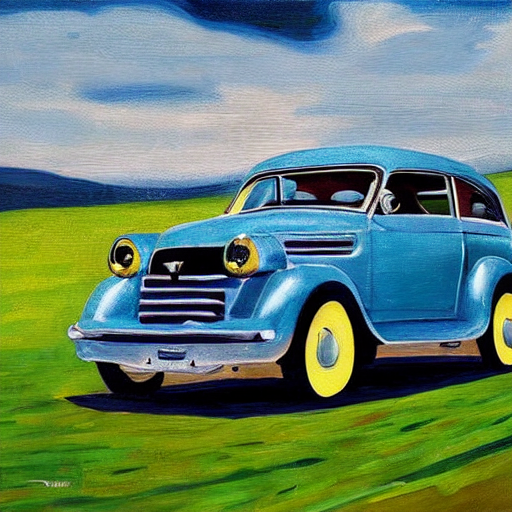

In [51]:
image